In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(4)

%load_ext autoreload
%autoreload 2

import h5py
import numpy as np
import scipy.optimize
import jax.numpy as jnp

import proplot as pplt

## Look at n(z) Distributions and Perturbations

In [2]:
from des_y6_nz_modeling import sompz_integral

with h5py.File("N_gamma_alpha_v0.hdf5") as d:
    z = d["tomography/zbinsc"][:].astype(np.float64)
    z = np.concatenate([[0.0], z])
    
    nzs = {}
    for _bin in range(4):
        nzs[_bin] = d[f"tomography/bin{_bin}"][:].astype(np.float64)
        nzs[_bin] = np.concatenate([[0.0], nzs[_bin]])
        nzs[_bin] = nzs[_bin] / np.asarray(sompz_integral(nzs[_bin], z, 0, 6.0))

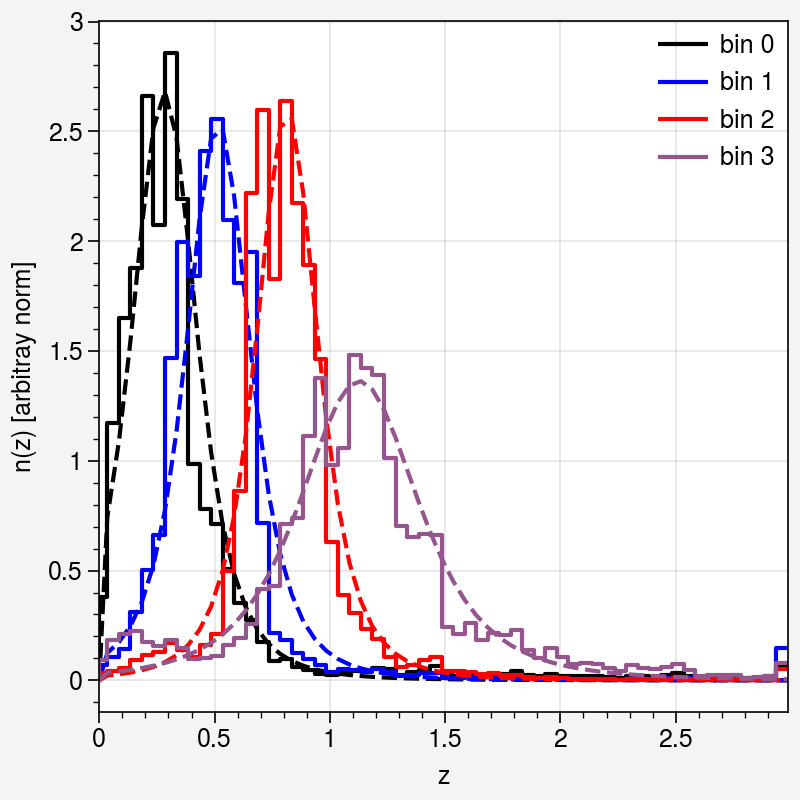

In [3]:
from mstudt4 import fit_nz_data_for_template_params, mstudt_nrm

params = fit_nz_data_for_template_params(z, nzs)

fig, axs = pplt.subplots(figsize=(4, 4))

for i, col in enumerate(["black", "blue", "red", "purple"]):
    popt = params[i]
    axs.plot(z, nzs[i], drawstyle="steps", color=col, label=f"bin {i}")
    axs.plot(z, mstudt_nrm(z, *popt), linestyle="dashed", color=col)

axs.format(xlabel="z", ylabel="n(z) [arbitray norm]")
axs.legend(loc="ur", frameon=False, ncols=1)

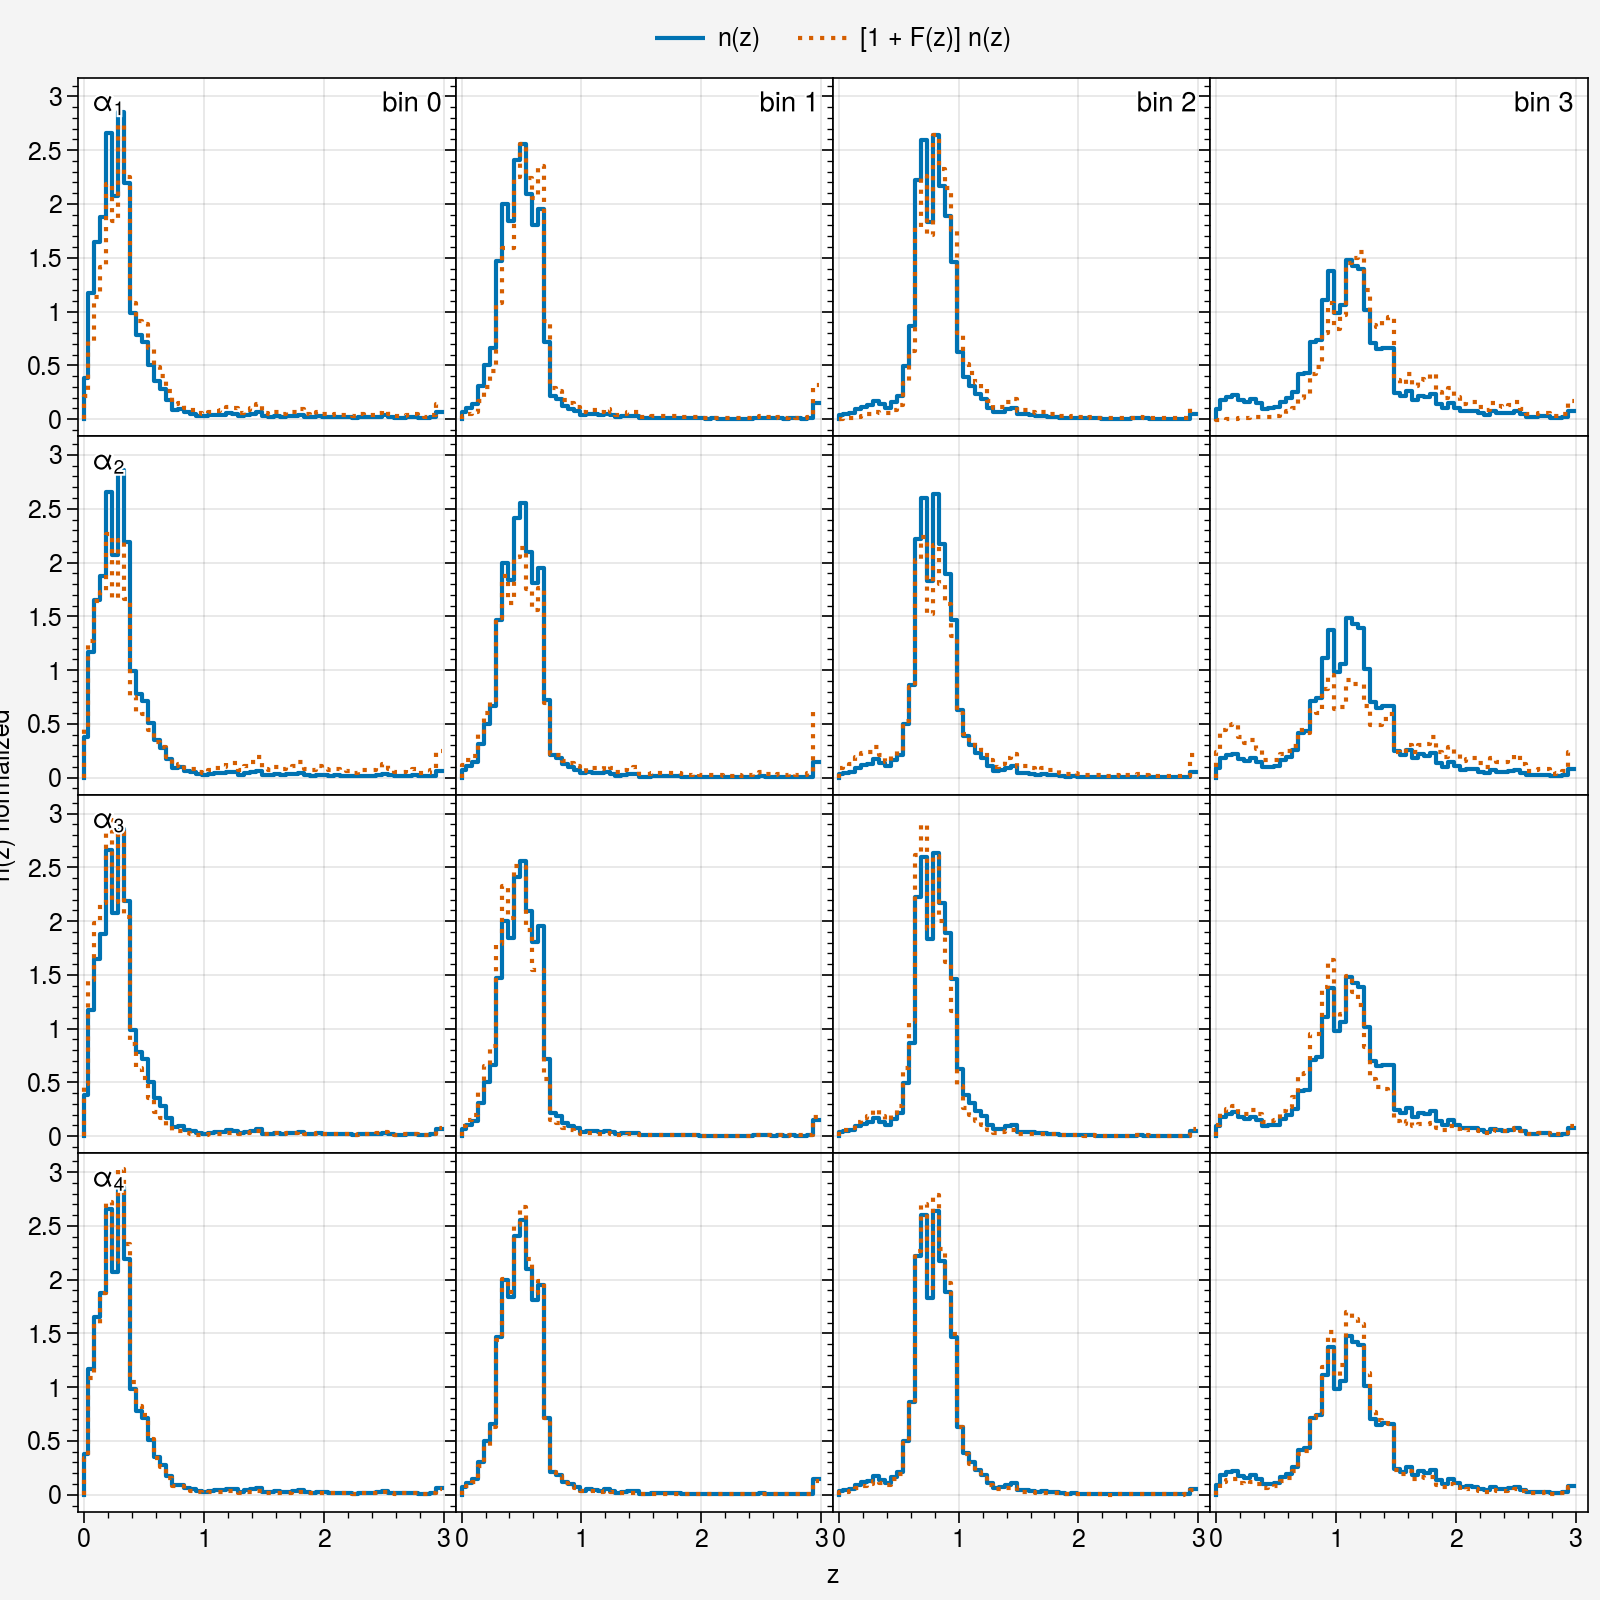

In [4]:
from mstudt4 import fmodel_mstudt4

scales = np.ones(4)

fig, axs = pplt.subplots(ncols=4, nrows=4, figsize=(8, 8), share=4, wspace=0, hspace=0)

for i in range(4):
    for row in range(4):
        ax = axs[row, i]
        avec = np.zeros(4)
        avec[row] = scales[row]

        nzi = nzs[i]
        stud_params = params[i]

        morig = ax.plot(z, nzi, drawstyle="steps", label="n(z)")
        mui = sompz_integral(nzs[i] * z, z, 0, 6)

        fac = 1.0 + fmodel_mstudt4(z, 0.0, avec[0], avec[1], avec[2], avec[3], mui, 1.0)  # stud_params[0], stud_params[1])
        nzi_fmodel = nzi * fac
        nzi_fmodel /= sompz_integral(nzi_fmodel, z, 0, 6)
        mmod = ax.plot(z, nzi_fmodel, drawstyle="steps", linestyle="dotted", label="[1 + F(z)] n(z)")

        ax.format(xlim=(-0.05, 3.1))
        if row == 0:
            ax.format(urtitle=f"bin {i}")
        if i == 0:
            ax.format(ultitle=f"$\\alpha_{row+1}$", ylabel="n(z) normalized")
        if row == 3:
            ax.format(xlabel="z")

fig.legend([morig, mmod], loc="t", frameon=False, ncols=3)

## Plot the N_gamma_alpha Data

In [5]:
with h5py.File("N_gamma_alpha_v0.hdf5") as d:
    mn = d["shear/mean"][:].astype(np.float64)
    cov = d["shear/cov"][:].astype(np.float64)
    mn_pars = tuple(tuple(v) for v in d["shear/mean_params"][:].astype(np.int64).tolist())
    zbins = []
    for zbin in range(-1, 10):
        zbins.append(d[f"alpha/bin{zbin}"][:].astype(np.float64))
    zbins = np.array(zbins)

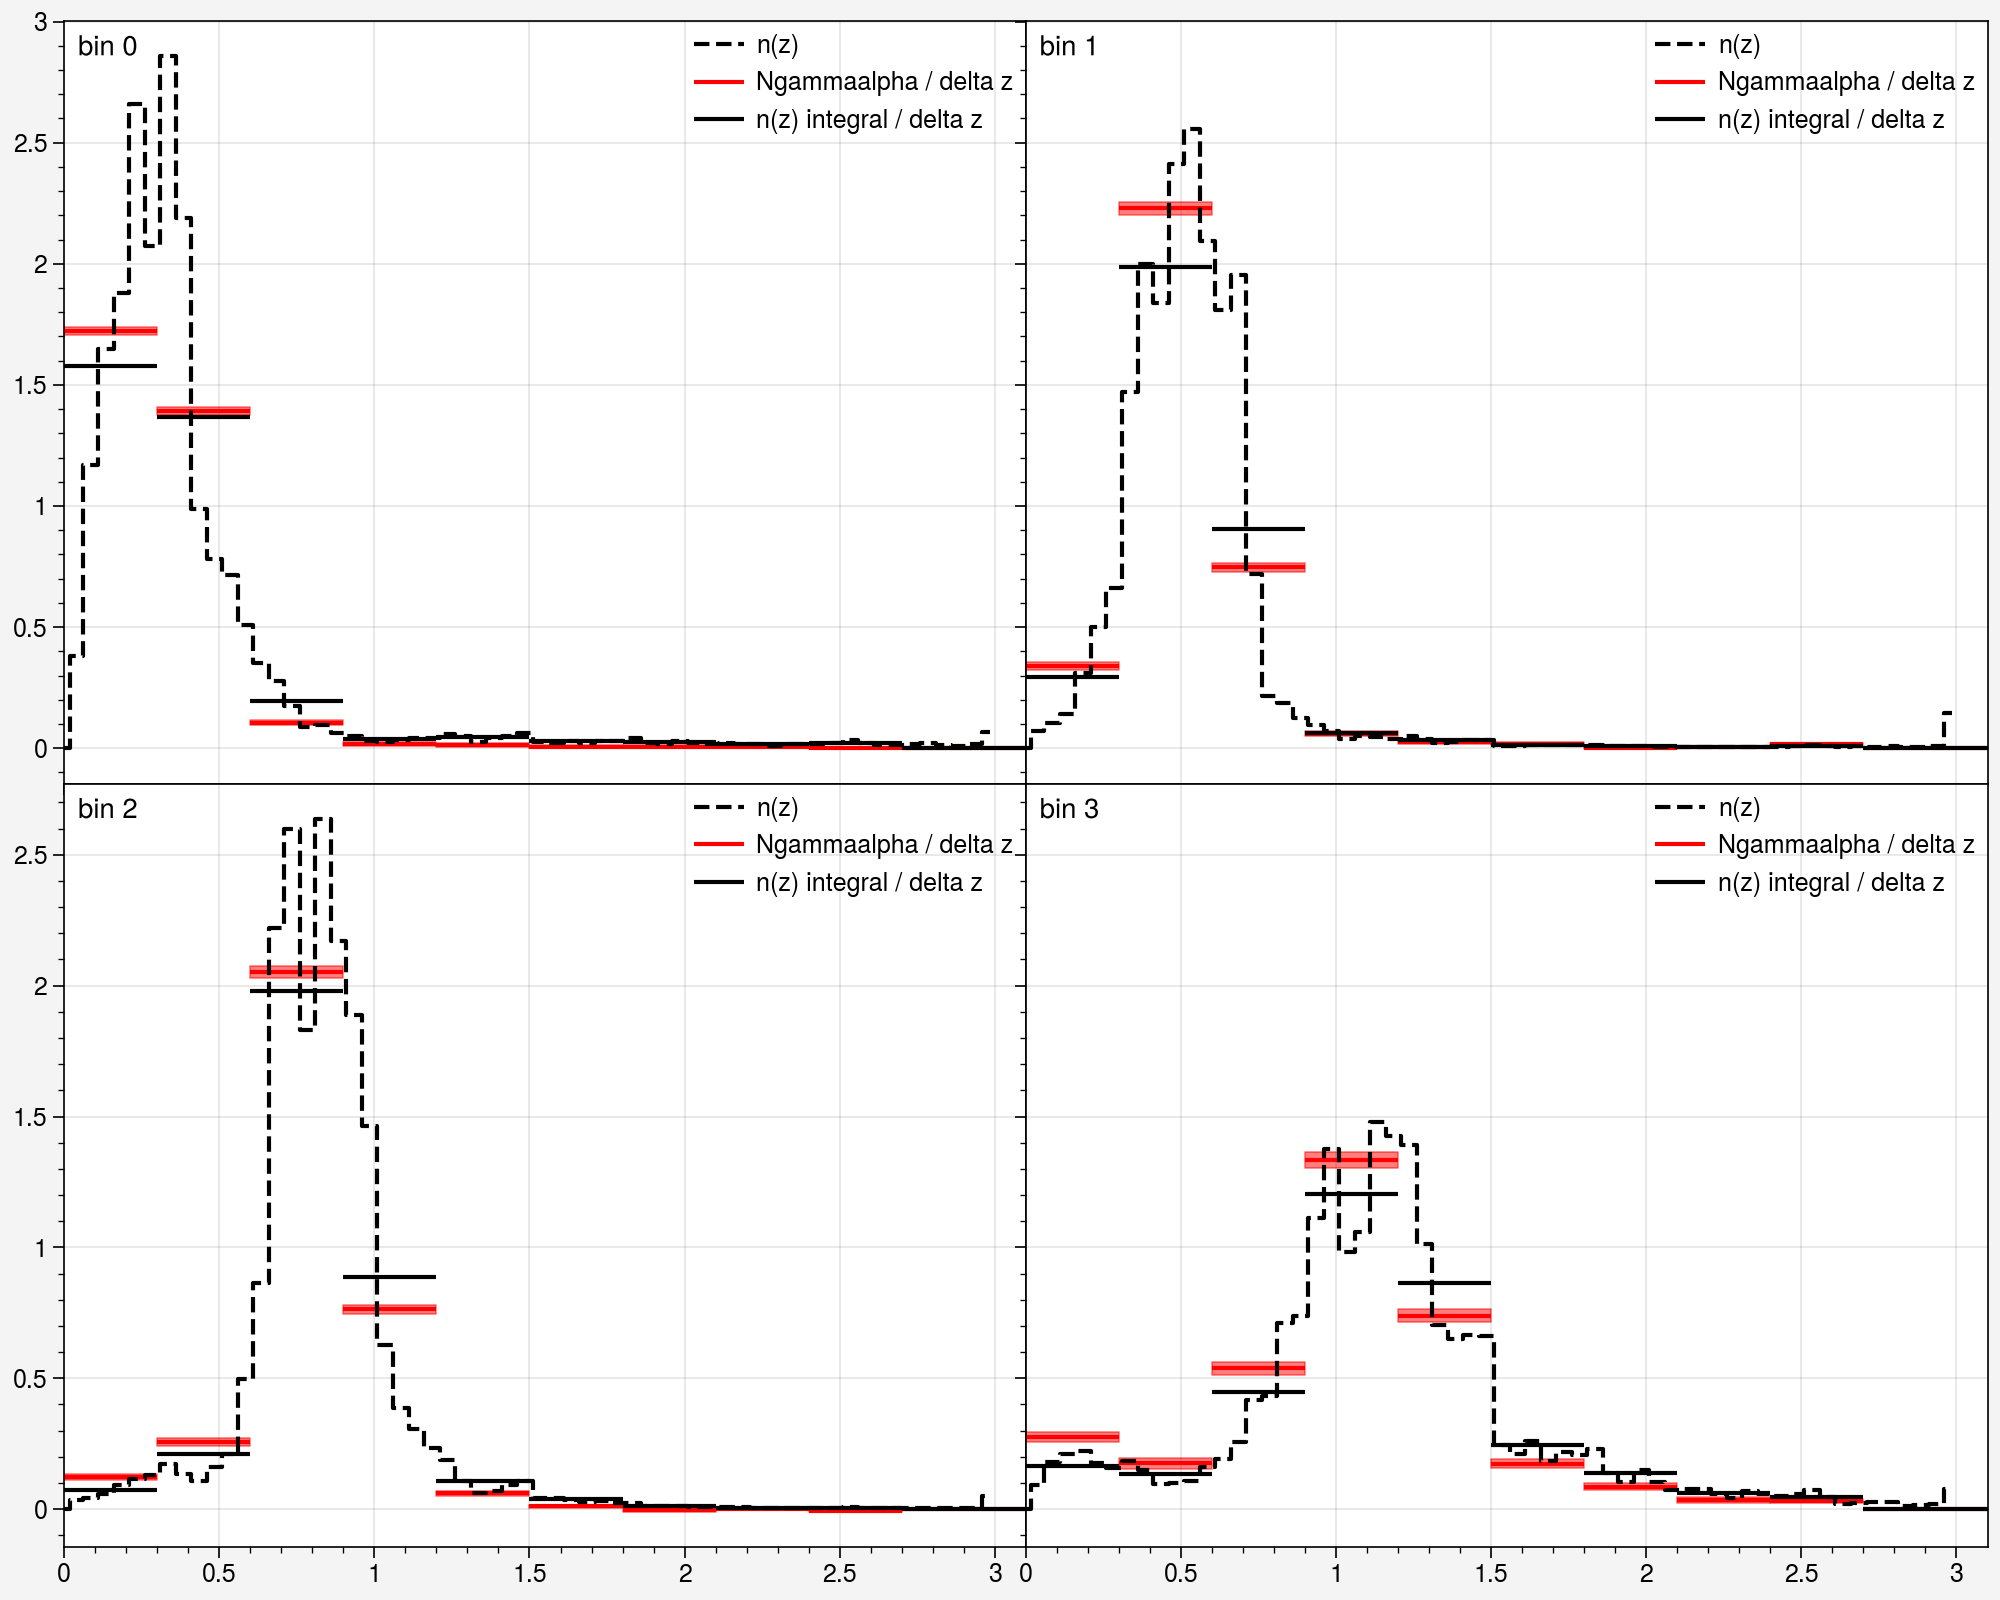

In [6]:
from des_y6_nz_modeling import sompz_integral

fig, axs = pplt.subplots(nrows=2, ncols=2, figsize=(10, 8), hspace=0, wspace=0)

for bi in range(4):
    biy, bix = np.unravel_index(bi, (2, 2))
    ax = axs[biy, bix]
    ax.plot(z, nzs[bi], drawstyle="steps-mid", color="black", linestyle="dashed", label="n(z)")

    for i in range(10):
        nind = mn_pars.index((i, bi))
        bin_zmin, bin_zmax = zbins[i+1]
        bin_dz = bin_zmax - bin_zmin
        nga_val = mn[nind] / bin_dz
        nga_err = np.sqrt(cov[nind, nind]) / bin_dz
        ax.fill_between(
            [bin_zmin, bin_zmax],
            np.ones(2) * nga_val - nga_err,
            np.ones(2) * nga_val + nga_err,
            color="red",
            alpha=0.5,
        )
            
        ax.hlines(
            mn[nind] / bin_dz, 
            bin_zmin, 
            bin_zmax, 
            color="red",
            label="Ngammaalpha / delta z" if i == 0 else None,
        )
        ng_val = sompz_integral(nzs[bi], z, bin_zmin, bin_zmax) / bin_dz
        ax.hlines(
            ng_val, 
            bin_zmin, 
            bin_zmax, 
            color="black",
            label="n(z) integral / delta z" if i == 0 else None,
        )
    ax.legend(loc="ur", frameon=False, ncols=1)
    ax.format(xlim=(0, 3.1), title=f"bin {bi}", titleloc="ul")
        

## Fit the Data

In [7]:
import numpyro
from numpyro.infer import MCMC, NUTS

In [123]:
import mstudt4
import polynomial
import hermite
import akima
import laguerre
import akima_frac

with h5py.File("N_gamma_alpha_v0.hdf5") as d:
    mn = d["shear/mean"][:].astype(np.float64)
    cov = d["shear/cov"][:].astype(np.float64) * 2.0
    mn_pars = tuple(tuple(v) for v in d["shear/mean_params"][:].astype(np.int64).tolist())
    zbins = []
    for zbin in range(-1, 10):
        zbins.append(d[f"alpha/bin{zbin}"][:].astype(np.float64))
    zbins = np.array(zbins)


model_module = akima_frac

model_data = model_module.make_model_data(
    z=z,
    nzs=nzs,
    mn=mn,
    cov=cov,
    mn_pars=mn_pars,
    zbins=zbins,
)

## MAP

In [124]:
import pprint
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, autoguide

guide = autoguide.AutoDelta(model_module.model)
optimizer = numpyro.optim.Adam(0.001)
svi = SVI(model_module.model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(
    random.PRNGKey(42),
    100000,
    **model_data,
)
map_params = svi_results.params

for key in list(map_params.keys()):
    if key.endswith("_auto_loc"):
        new_key = key[:-len("_auto_loc")]
        map_params[new_key] = map_params[key]
        del map_params[key]
print(pprint.pformat(map_params))

100%|██████████████████████████████████████████████████████████████| 100000/100000 [00:20<00:00, 4815.71it/s, init loss: 1492731.1704, avg. loss [95001-100000]: -78.3104]


{'a0_b0': Array(0.2449189, dtype=float64),
 'a0_b1': Array(-0.02878462, dtype=float64),
 'a0_b2': Array(0.08396658, dtype=float64),
 'a0_b3': Array(0.18530889, dtype=float64),
 'a1_b0': Array(0.02425385, dtype=float64),
 'a1_b1': Array(0.34134111, dtype=float64),
 'a1_b2': Array(0.03731643, dtype=float64),
 'a1_b3': Array(0.01203993, dtype=float64),
 'a2_b0': Array(-0.11518603, dtype=float64),
 'a2_b1': Array(-0.3149905, dtype=float64),
 'a2_b2': Array(0.14522777, dtype=float64),
 'a2_b3': Array(0.08330471, dtype=float64),
 'a3_b0': Array(0.00709433, dtype=float64),
 'a3_b1': Array(0.04269371, dtype=float64),
 'a3_b2': Array(-0.17350192, dtype=float64),
 'a3_b3': Array(0.19898048, dtype=float64),
 'a4_b0': Array(-0.03764418, dtype=float64),
 'a4_b1': Array(-0.02876325, dtype=float64),
 'a4_b2': Array(-0.01871527, dtype=float64),
 'a4_b3': Array(-0.18726227, dtype=float64),
 'a5_b0': Array(-0.01786314, dtype=float64),
 'a5_b1': Array(0.00609044, dtype=float64),
 'a5_b2': Array(-0.025825

In [125]:
model_mn = model_module.model_mean(
    params=map_params,
    **model_data,
)
dmn = model_mn - mn
chi2 = np.dot(dmn, np.dot(np.linalg.inv(model_data["cov"]), dmn.T))
print("chi2:", chi2)
print("dof:", mn.shape[0] - len(map_params))
print("m vals:\n    model: %r\n    data: %r\n     err: %r" % (
    (model_mn[:4]-1).tolist(), 
    (mn[:4]-1).tolist(),
    (np.sqrt(np.diag(cov)[:4])).tolist(),
))

chi2: 3.7685091954092527
dof: 4
m vals:
    model: [-0.0009944725062212, -0.004806857650020091, 0.001584054380914024, 0.026976098029986906]
    data: [-0.0014702142889351233, -0.0010137336059889979, -3.941527629247599e-05, 0.027942675052796462]
     err: [0.009664048691070374, 0.012860970484861857, 0.011709298225765408, 0.02127715219010826]


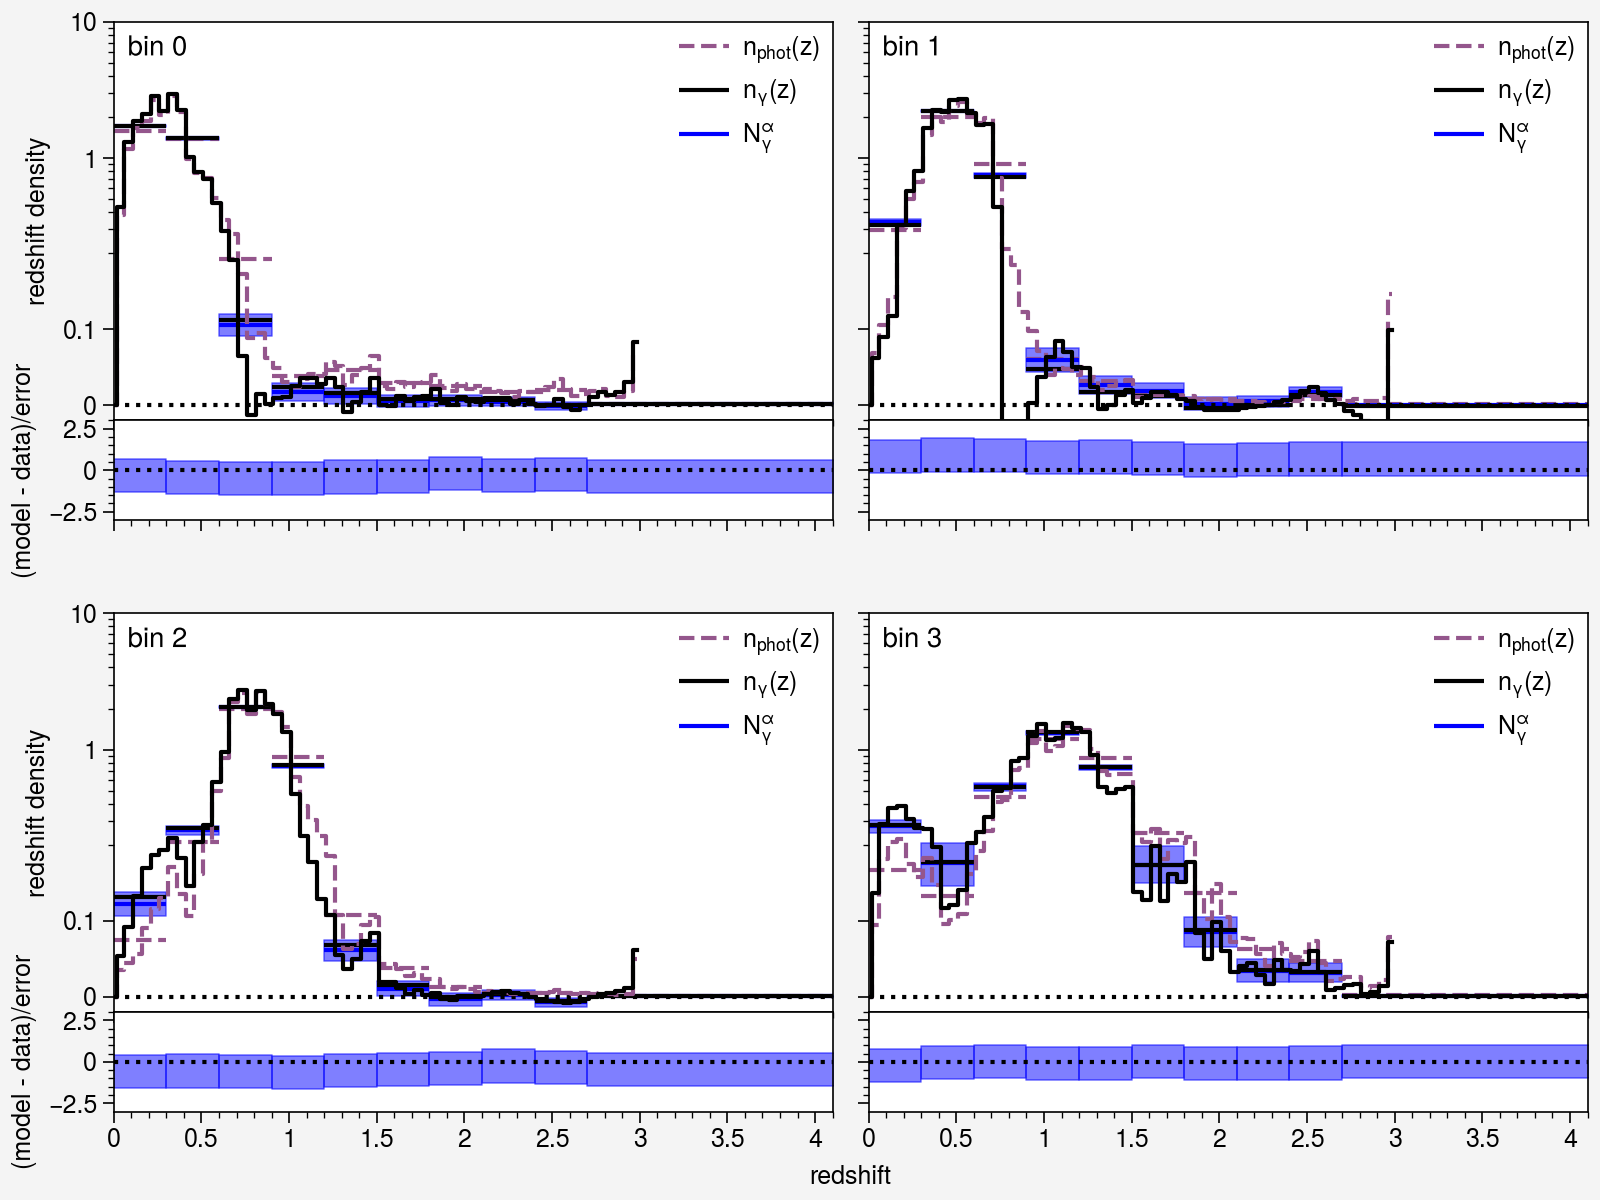

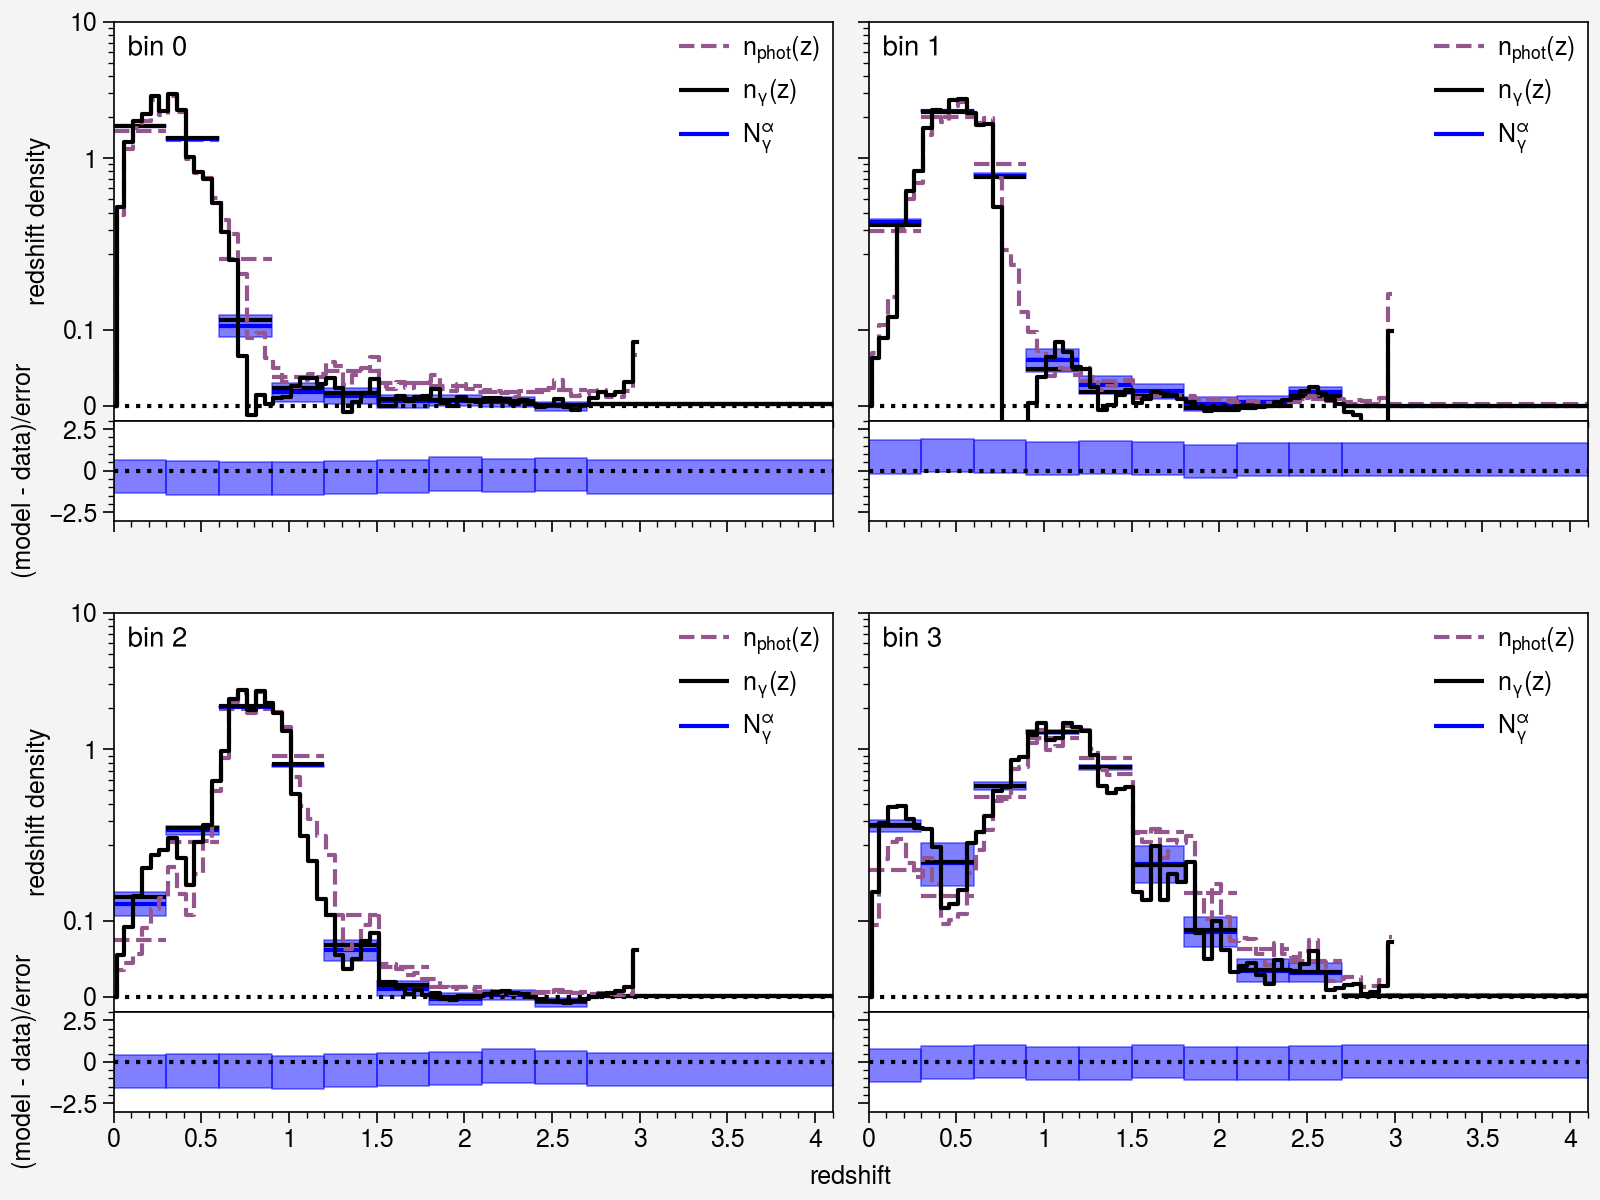

In [126]:
from des_y6_nz_modeling import plot_results

plot_results(model_module=model_module, model_data=model_data, map_params=map_params)

# MCMC

In [127]:
from jax import random
from numpyro.infer import init_to_sample, init_to_value

rng_key = random.PRNGKey(42)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(
    model_module.model, 
    init_strategy=init_to_sample(),  # init_to_value(values=map_params), 
)
mcmc = MCMC(
    kernel, 
    num_warmup=500, 
    num_samples=1000, 
    num_chains=4, 
)
mcmc.run(
    rng_key_,
    **model_data,
)
mcmc.print_summary()
samples = mcmc.get_samples()

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0      0.24      0.03      0.24      0.19      0.30   3486.05      1.00
     a0_b1     -0.03      0.03     -0.03     -0.08      0.03   3054.25      1.00
     a0_b2      0.08      0.02      0.08      0.04      0.12   3400.05      1.00
     a0_b3      0.19      0.04      0.19      0.12      0.26   2887.07      1.00
     a1_b0      0.02      0.03      0.02     -0.02      0.08   2928.53      1.00
     a1_b1      0.34      0.05      0.34      0.27      0.42   2744.23      1.00
     a1_b2      0.04      0.03      0.04     -0.01      0.08   2996.19      1.00
     a1_b3      0.01      0.04      0.01     -0.05      0.08   2747.45      1.00
     a2_b0     -0.12      0.02     -0.12     -0.15     -0.08   3920.77      1.00
     a2_b1     -0.31      0.03     -0.32     -0.37     -0.26   2704.71      1.00
     a2_b2      0.15      0.04      0.15      0.08      0.21   2460.70      1.00
     a2_b3      0.08      0

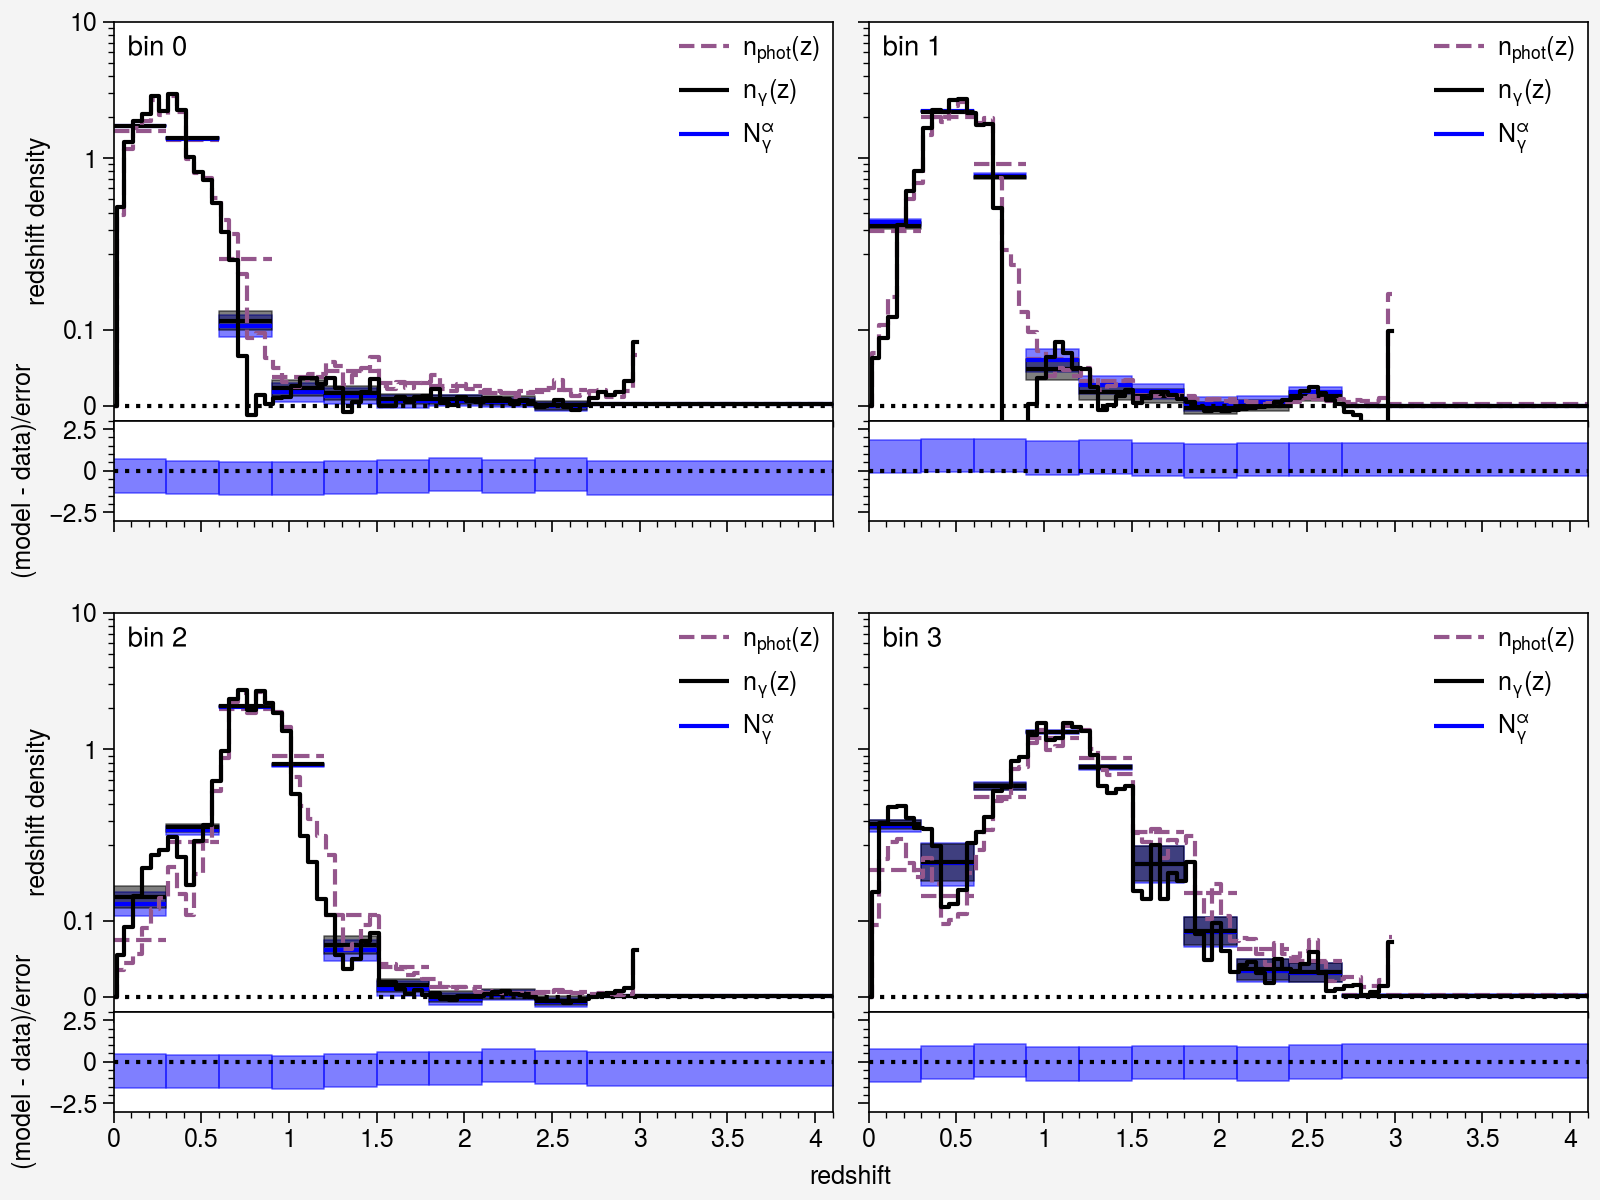

In [128]:
from des_y6_nz_modeling import plot_results

fig = plot_results(model_module=model_module, model_data=model_data, samples=samples)
fig.savefig("fgfit.pdf")
fig.savefig("fgfit.png", dpi=600)

In [129]:
from des_y6_nz_modeling import measure_m_dz

data = measure_m_dz(model_module=model_module, model_data=model_data, samples=samples, return_dict=False)

In [130]:
m_mn = data.mean(axis=0)[[0, 2, 4, 6]]
m_sd = data.std(axis=0, ddof=1)[[0, 2, 4, 6]]

dz_mn = data.mean(axis=0)[[1, 3, 5, 7]]
dz_sd = data.std(axis=0, ddof=1)[[1, 3, 5, 7]]

In [131]:
print("|--------------------------------------------|")
print("| bin | m [10^-3, 3sigma] | dz               |")
print("|--------------------------------------------|")
for i in range(4):
    print("| %d   | %+5.1f +/- %-5.1f   | %+0.3f +/- %0.3f |" % (i, m_mn[i]/1e-3, m_sd[i]/1e-3 * 3, dz_mn[i], dz_sd[i]))
print("|--------------------------------------------|")

|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz               |
|--------------------------------------------|
| 0   |  -1.1 +/- 28.8    | -0.063 +/- 0.008 |
| 1   |  -5.1 +/- 37.3    | -0.050 +/- 0.012 |
| 2   |  +1.8 +/- 34.4    | -0.049 +/- 0.010 |
| 3   | +27.4 +/- 62.1    | -0.106 +/- 0.018 |
|--------------------------------------------|
